# Face Alignment

From 
1. https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
2. https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/

In [1]:
import numpy as np
import dlib
import cv2
from collections import OrderedDict
import imutils
from matplotlib import pyplot as plt

In [2]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

#For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
    ("right_eye", (2, 3)),
    ("left_eye", (0, 1)),
    ("nose", (4))
])

# in order to support legacy code, we'll default the indexes to the
# 68-point model
FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

def rect_to_bb(rect):
    '''
    
    :param rect:
    :type rect:
    
    :return: 
    :rtype: tuple of length 4
    '''
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    # create two copies of the input image -- one for the
    # overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()

    # if the colors list is None, initialize it with a unique
    # color for each facial landmark region
    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
            (168, 100, 168), (158, 163, 32),
            (163, 38, 32), (180, 42, 220), (0, 0, 255)]

    # loop over the facial landmark regions individually
    for (i, name) in enumerate(FACIAL_LANDMARKS_IDXS.keys()):
        # grab the (x, y)-coordinates associated with the
        # face landmark
        (j, k) = FACIAL_LANDMARKS_IDXS[name]
        pts = shape[j:k]

        # check if are supposed to draw the jawline
        if name == "jaw":
            # since the jawline is a non-enclosed facial region,
            # just draw lines between the (x, y)-coordinates
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        # otherwise, compute the convex hull of the facial
        # landmark coordinates points and display it
        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    # apply the transparent overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    # return the output image
    return output

In [28]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.25, 0.25),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        #simple hack ;)
        if (len(shape)==68):
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = np.array([(leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2], dtype=float)
                
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output

In [29]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [30]:
fa = FaceAligner(predictor, desiredFaceWidth=256)

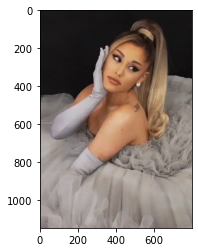

In [31]:
image = cv2.imread("../images/ariana_grande_2.png")
image = imutils.resize(image, width=800)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# show the original input image and detect faces in the grayscale
# image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
rects = detector(gray, 2)

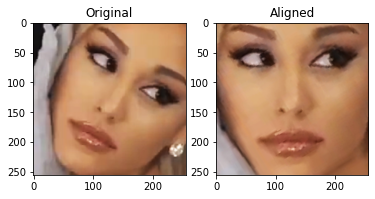

In [32]:
# loop over the face detections
for rect in rects:
    # extract the ROI of the *original* face, then align the face
    # using facial landmarks
    (x, y, w, h) = rect_to_bb(rect)
    faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
    faceAligned = fa.align(image, gray, rect)
    
    # display the output images
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].set_title('Original')
    ax[0].imshow(cv2.cvtColor(faceOrig, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Aligned')
    ax[1].imshow(cv2.cvtColor(faceAligned, cv2.COLOR_BGR2RGB))
    plt.show()